
# Projeto Integrado de Deep Learning para Séries Temporais de Ações (TensorFlow)

O que contém neste notebook:

- Pipeline de _preprocessing_ com padronização e criação de janelas;
- Modelos: **CNN1D, LSTM e GRU (escolha por parâmetro);**
- Métricas no conjunto de **teste**: **acurácia**, **matriz de confusão**, **precision** e **recall**;
- **Backtest** para avaliar retorno financeiro (com custo de transação configurável);
- Callbacks (EarlyStopping, ReduceLROnPlateau) e salvamento de modelos por ativo.

> **Como usar**: Preencha o dicionário `ASSETS` com os caminhos dos seus CSVs de treino e teste (podem ser caminhos locais ou do Google Drive após montar a unidade).


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:

# Utilizando Google Colab:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:

!python --version
import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())


Python 3.12.11
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.6.97+-x86_64-with-glibc2.35


In [14]:
# Instalações

%pip install -q tensorflow numpy pandas scikit-learn matplotlib


In [15]:
# Importação bibliotecas

import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Dict, Tuple, List

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0



## 1) Configurações principais
Ajuste abaixo os caminhos dos arquivos e os nomes de colunas. O notebook tenta **auto-detectar** colunas típicas (Date/Close/Label).


In [16]:

# Configurando diretórios

# Diretório de Assets utilizado (Fazer alteração de acordo com o seu uso)
ASSETS = {
    "PETR4": {"train_csv": "/content/drive/MyDrive/colab/copy/treino_p.csv", "test_csv": "/content/drive/MyDrive/colab/copy/teste_p.csv"},
    "VALE3": {"train_csv": "/content/drive/MyDrive/colab/copy/treino_v.csv", "test_csv": "/content/drive/MyDrive/colab/copy/teste_v.csv"},
    "BBAS3": {"train_csv": "/content/drive/MyDrive/colab/copy/treino_b.csv", "test_csv": "/content/drive/MyDrive/colab/copy/treino_b.csv"},
    "CSNA3": {"train_csv": "/content/drive/MyDrive/colab/copy/treino_c.csv", "test_csv": "/content/drive/MyDrive/colab/copy/teste_c.csv"},
}

# Parâmetros gerais
WINDOW_SIZE = 15            # tamanho da janela (dias)
HORIZON = 1                 # prever 1 passo à frente
BATCH_SIZE = 128
EPOCHS = 30
PATIENCE = 5
VAL_SPLIT = 0.1             # Para treino (validação a partir do treino)

# Nomes de colunas (Se usar nomes exatos, defina aqui. Caso não, deixar como None para auto-detectar)
DATE_COL = None   # ex.: "Date"
PRICE_COL = None
LABEL_COL = None  # ex.: "label" (0/1). Se não existir, vamos usar com base em retorno futuro > 0

# Rotulagem se LABEL_COL for None:
# "future_return_pos" -> 1 se retorno (t+HORIZON vs t) > 0, senão 0
LABELING_STRATEGY = "future_return_pos"

# Escolha do modelo: "cnn1d", "lstm", "gru"
MODEL_TYPE = "gru"

# Classe minoritária pode receber peso maior para lidar com desbalanceamento
USE_CLASS_WEIGHTS = True

# Caminho para salvar modelos e relatórios
OUTPUT_DIR = Path("outputs_dl_timeseries")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Backtest
DO_BACKTEST = True
TRANSACTION_COST = 0.0005  # custo proporcional por trade



## 2) Leitura e Preparação
- Leitura flexível de CSVs com **auto-detecção** de colunas.
- Criação de janelas (sequências) para **supervisionar** a previsão (classificação binária).
- Padronização dos recursos com `StandardScaler` (fit no treino, apply no teste).


In [17]:

def autodetect_columns(df: pd.DataFrame,
                       date_col: str = None,
                       price_col: str = None,
                       label_col: str = None) -> Tuple[str, str, str]:
    cols = [c.lower() for c in df.columns]
    colmap = {c.lower(): c for c in df.columns}

    # Date
    if date_col is None:
        for cand in ["date", "data", "timestamp"]:
            if cand in cols:
                date_col = colmap[cand]
                break
    if date_col is None:
        # cria uma coluna de índice se não existir
        date_col = None

    # Price
    if price_col is None:
        for cand in ["close", "adj close", "price", "preco", "close_price"]:
            if cand in cols:
                price_col = colmap[cand]
                break
    if price_col is None:
        # tenta último numérico
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) == 0:
            raise ValueError("Não foi possível detectar coluna de preço numérica.")
        price_col = numeric_cols[0]

    # Label
    if label_col is None:
        for cand in ["label", "y", "target", "classe"]:
            if cand in cols:
                label_col = colmap[cand]
                break

    return date_col, price_col, label_col


def make_labels_from_price(prices: np.ndarray, horizon: int = 1):
    # 1 se preço futuro > preço atual, senão 0
    fut = np.roll(prices, -horizon)
    y = (fut > prices).astype(int)
    # últimas posições ficam indefinidas -> removidas no corte de janelas
    return y


def build_windows(features: np.ndarray, labels: np.ndarray, window_size: int, horizon: int) -> Tuple[np.ndarray, np.ndarray]:
    X_list, y_list = [], []
    limit = len(features) - window_size - horizon + 1
    for i in range(limit):
        X_list.append(features[i:i+window_size])
        y_list.append(labels[i+window_size-1])  # rótulo no fim da janela
    return np.array(X_list), np.array(y_list)


def load_dataset(csv_path: str,
                 date_col_conf=None,
                 price_col_conf=None,
                 label_col_conf=None,
                 window_size: int = 15,
                 horizon: int = 1) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame, dict]:
    df = pd.read_csv(csv_path)
    dcol, pcol, lcol = autodetect_columns(df, date_col_conf, price_col_conf, label_col_conf)

    meta = {"date_col": dcol, "price_col": pcol, "label_col": lcol}

    if dcol is not None:
        df[dcol] = pd.to_datetime(df[dcol])

    # Monta 'features' a partir de colunas numéricas
    num = df.select_dtypes(include=[np.number]).copy()
    if num.empty:
        raise ValueError("O CSV não contém colunas numéricas para usar como features.")

    # Garante que a coluna de preço esteja presente primeiro
    if pcol not in num.columns:
        raise ValueError(f"Coluna de preço '{pcol}' não encontrada entre numéricas.")
    cols = [pcol] + [c for c in num.columns if c != pcol]
    num = num[cols]

    # Labels
    if lcol is None:
        labels = make_labels_from_price(num[pcol].values, horizon=horizon)
    else:
        labels = df[lcol].values.astype(int)

    # Padronização (fit/transform será feito no pipeline global)
    features = num.values.astype(float)

    return features, labels, df, meta



## 3) Modelos (CNN1D / LSTM / GRU)
Cada modelo retorna uma rede simples porém eficaz para janelas de 15 dias.


In [18]:
def make_cnn1d(input_shape, n_classes=2):
    from tensorflow import keras
    from tensorflow.keras import layers

    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(64, 3, padding="causal", activation="relu")(inputs)
    x = layers.Conv1D(64, 3, padding="causal", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(128, 3, padding="causal", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    if n_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(x)
        loss = "binary_crossentropy"
        metrics = ["accuracy"]
    else:
        outputs = layers.Dense(n_classes, activation="softmax")(x)
        loss = "sparse_categorical_crossentropy"
        metrics = ["accuracy"]

    model = keras.Model(inputs, outputs, name="cnn1d")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss, metrics=metrics)
    return model


def make_lstm(input_shape, n_classes=2):
    from tensorflow import keras
    from tensorflow.keras import layers

    inputs = keras.Input(shape=input_shape)
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    if n_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(x)
        loss = "binary_crossentropy"
    else:
        outputs = layers.Dense(n_classes, activation="softmax")(x)
        loss = "sparse_categorical_crossentropy"

    model = keras.Model(inputs, outputs, name="lstm")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss, metrics=["accuracy"])
    return model


def make_gru(input_shape, n_classes=2):
    from tensorflow import keras
    from tensorflow.keras import layers

    inputs = keras.Input(shape=input_shape)
    x = layers.GRU(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.GRU(64)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    if n_classes == 2:
        outputs = layers.Dense(1, activation="sigmoid")(x)
        loss = "binary_crossentropy"
    else:
        outputs = layers.Dense(n_classes, activation="softmax")(x)
        loss = "sparse_categorical_crossentropy"

    model = keras.Model(inputs, outputs, name="gru")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss, metrics=["accuracy"])
    return model


## 4) Treino, avaliação e backtest
Inclui:
- EarlyStopping e ReduceLROnPlateau
- Métricas no **conjunto de teste**
- Backtest simples: entra comprado quando `pred=1`, sai quando `pred=0` (custo proporcional)


In [19]:
def train_evaluate_one_asset(name: str,
                             train_csv: str,
                             test_csv: str,
                             model_type: str = "cnn1d",
                             window_size: int = 15,
                             horizon: int = 1,
                             use_class_weights: bool = True,
                             do_backtest: bool = True,
                             transaction_cost: float = 0.0005,
                             date_col=DATE_COL, price_col=PRICE_COL, label_col=LABEL_COL,
                             output_dir: Path = OUTPUT_DIR) -> dict:
    output_dir = Path(output_dir) / name
    output_dir.mkdir(parents=True, exist_ok=True)

    # Carrega dados
    Xtr_raw, ytr_raw, df_tr, meta_tr = load_dataset(train_csv, date_col, price_col, label_col, window_size, horizon)
    Xte_raw, yte_raw, df_te, meta_te = load_dataset(test_csv, date_col, price_col, label_col, window_size, horizon)


    # Padronização por coluna (fit no treino)
    scaler = StandardScaler()
    Xtr_scaled = scaler.fit_transform(Xtr_raw)
    Xte_scaled = scaler.transform(Xte_raw)

    # Constrói janelas
    Xtr, ytr = build_windows(Xtr_scaled, ytr_raw, window_size, horizon)
    Xte, yte = build_windows(Xte_scaled, yte_raw, window_size, horizon)

    # Ajusta shapes para [batch, timesteps, features]

    if Xtr.ndim == 2:

        Xtr = Xtr.reshape(-1, window_size, 1)
        Xte = Xte.reshape(-1, window_size, 1)

    # Remapeia labels para 0..n_classes-1
    def remap_labels(y):
        classes = np.unique(y)
        class2idx = {c:i for i,c in enumerate(classes)}
        y_mapped = np.vectorize(class2idx.get)(y)
        return y_mapped, classes, class2idx

    ytr_m, classes_tr, map_tr = remap_labels(ytr)
    yte_m = np.vectorize(map_tr.get)(yte)  # usa o mesmo mapeamento do treino
    if np.any([v is None for v in np.vectorize(map_tr.get)(np.unique(yte))]):
        # caso apareça classe nova só no teste, remapeia globalmente
        all_classes = np.unique(np.concatenate([ytr, yte]))
        glob_map = {c:i for i,c in enumerate(all_classes)}
        ytr_m = np.vectorize(glob_map.get)(ytr)
        yte_m = np.vectorize(glob_map.get)(yte)
        classes_tr = all_classes

    n_classes = len(classes_tr)
    is_binary = (n_classes == 2)

    # Modelo com cabeça compatível
    input_shape = (window_size, Xtr.shape[2])
    if model_type == "cnn1d":
        model = make_cnn1d(input_shape, n_classes=n_classes)
    elif model_type == "lstm":
        model = make_lstm(input_shape, n_classes=n_classes)
    elif model_type == "gru":
        model = make_gru(input_shape, n_classes=n_classes)
    else:
        raise ValueError("MODEL_TYPE inválido.")

    # Class weights
    class_weight = None
    if use_class_weights:
        # frequência por classe em ytr_m (0..n_classes-1)
        counts = np.bincount(ytr_m, minlength=n_classes)
        total = counts.sum()
        class_weight = {i: float(total / (n_classes * counts[i])) for i in range(n_classes) if counts[i] > 0}

    callbacks = [
        keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(patience=max(1, PATIENCE//2), factor=0.5, verbose=1),
    ]

    history = model.fit(
        Xtr, ytr_m,
        validation_split=VAL_SPLIT,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )

    # --- Predições e métricas
    yraw = model.predict(Xte)
    if is_binary:
        yproba = yraw.ravel()
        ypred_m = (yproba >= 0.5).astype(int)
    else:
        ypred_m = np.argmax(yraw, axis=1)

    # métricas sklearn (respeitando multiclasses)
    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

    acc = accuracy_score(yte_m, ypred_m)
    if is_binary:
        prec = precision_score(yte_m, ypred_m, zero_division=0)
        rec  = recall_score(yte_m, ypred_m, zero_division=0)
    else:
        # escolha 'macro' ou 'weighted' se dataset for muito desbalanceado
        prec = precision_score(yte_m, ypred_m, average='macro', zero_division=0)
        rec  = recall_score(yte_m, ypred_m, average='macro', zero_division=0)

    cm = confusion_matrix(yte_m, ypred_m, labels=list(range(n_classes)))

    # Salva métricas/artefatos
    report = {
        "asset": name,
        "model_type": model_type,
        "test_accuracy": float(acc),
        "test_precision": float(prec),
        "test_recall": float(rec),
        "confusion_matrix": cm.tolist(),
        "class_weight": class_weight
    }
    with open(output_dir / "report.json", "w") as f:
        json.dump(report, f, indent=2)


    backtest_summary = None
    if DO_BACKTEST and is_binary:
        price_col = meta_te["price_col"]
        prices_test = df_te.select_dtypes(include=[np.number])[price_col].values
        start = window_size - 1
        pr = prices_test[start : start + len(yte_m)]
        rets = np.zeros_like(pr, dtype=float)
        rets[1:] = (pr[1:] - pr[:-1]) / pr[:-1]

        pos = ypred_m.astype(int)  # 1 comprado, 0 fora
        trades = np.abs(np.diff(np.r_[0, pos]))
        strategy_rets = pos * rets - trades * TRANSACTION_COST

        cum_strategy = (1 + strategy_rets).cumprod()
        cum_buyhold = (1 + rets).cumprod()

        backtest_summary = {
            "strategy_final_return_multiple": float(cum_strategy[-1]),
            "buy_and_hold_final_return_multiple": float(cum_buyhold[-1]),
            "avg_daily_ret_strategy": float(strategy_rets.mean()),
            "avg_daily_ret_bh": float(rets.mean()),
            "n_trades": int(trades.sum()),
            "transaction_cost": float(TRANSACTION_COST)
        }

        with open(output_dir / "backtest.json", "w") as f:
            json.dump(backtest_summary, f, indent=2)

        # Plota equity curve
        import matplotlib.pyplot as plt
        plt.figure(figsize=(9,5))
        plt.plot(cum_strategy, label="Estratégia (pred=1 comprado)")
        plt.plot(cum_buyhold, label="Buy & Hold")
        plt.title(f"Backtest - {name} ({model_type})")
        plt.xlabel("Dias (janela alinhada)")
        plt.ylabel("Multiplicador de capital")
        plt.legend()
        plt.tight_layout()
        plt.savefig(output_dir / "backtest_equity.png", dpi=150)
        plt.close()

    # Salva matriz de confusão
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"Matriz de Confusão - {name} ({model_type})")
    ax.set_xlabel("Predito")
    ax.set_ylabel("Verdadeiro")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    fig.savefig(output_dir / "confusion_matrix.png", dpi=150)
    plt.close(fig)

    return {"report": report, "backtest": backtest_summary}


## 5) Loop pelos 4 ativos
Preencha `ASSETS` e execute.


In [20]:

all_results = {}
if len(ASSETS) == 0:
    print("")
else:
    for asset, paths in ASSETS.items():
        print(f"\n===== Treinando {asset} ({MODEL_TYPE}) =====")
        res = train_evaluate_one_asset(
            name=asset,
            train_csv=paths["train_csv"],
            test_csv=paths["test_csv"],
            model_type=MODEL_TYPE,
            window_size=WINDOW_SIZE,
            horizon=HORIZON,
            use_class_weights=USE_CLASS_WEIGHTS,
            do_backtest=DO_BACKTEST,
            transaction_cost=TRANSACTION_COST,
            date_col=DATE_COL, price_col=PRICE_COL, label_col=LABEL_COL,
            output_dir=OUTPUT_DIR
        )
        all_results[asset] = res

    # Sumário rápido
    summary_rows = []
    for asset, res in all_results.items():
        r = res["report"]
        bt = res.get("backtest")
        row = {
            "asset": asset,
            "model": r["model_type"],
            "acc_test": r["test_accuracy"],
            "precision": r["test_precision"],
            "recall": r["test_recall"],
        }
        if bt is not None:
            row.update({
                "final_mult_strategy": bt["strategy_final_return_multiple"],
                "final_mult_bh": bt["buy_and_hold_final_return_multiple"],
                "n_trades": bt["n_trades"]
            })
        summary_rows.append(row)

    if summary_rows:
        df_sum = pd.DataFrame(summary_rows)
        display(df_sum)
        df_sum.to_csv(OUTPUT_DIR / "summary.csv", index=False)
        print(f"Relatórios salvos em: {OUTPUT_DIR.resolve()}")



===== Treinando PETR4 (gru) =====
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.7656 - loss: 0.5467 - val_accuracy: 0.8958 - val_loss: 0.2480 - learning_rate: 0.0010
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9305 - loss: 0.1958 - val_accuracy: 0.9937 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9965 - loss: 0.0380 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 4.8330e-04 - learning_rate: 0.0010
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 2.3974e-04 - learning_rate: 0.0010
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 1.0000 - loss: 8.8999e-04 - val_accuracy: 1.0000 - val_loss: 1.4079e-04 - learning_rate: 0.0010
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 98

,asset,model,acc_test,precision,recall,final_mult_strategy,final_mult_bh,n_trades
0,PETR4,gru,0.992424,0.985390,1.000000,8.260572,3.620412,105
1,VALE3,gru,0.956229,0.945092,0.967632,3.525248,2.244225,91
2,BBAS3,gru,1.000000,1.000000,1.000000,6201.816432,34.444169,376
3,CSNA3,gru,1.000000,1.000000,1.000000,20.401324,1.814886,83


Relatórios salvos em: /content/outputs_dl_timeseries


from matplotlib import pyplot as plt
df_sum['acc_test'].plot(kind='hist', bins=20, title='acc_test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_sum['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_sum['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_sum['final_mult_strategy'].plot(kind='hist', bins=20, title='final_mult_strategy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_sum.groupby('asset').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_sum.plot(kind='scatter', x='acc_test', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_sum.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_sum.plot(kind='scatter', x='recall', y='final_mult_strategy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_sum.plot(kind='scatter', x='final_mult_strategy', y='final_mult_bh', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_sum['acc_test'].plot(kind='line', figsize=(8, 4), title='acc_test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_sum['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_sum['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_sum['final_mult_strategy'].plot(kind='line', figsize=(8, 4), title='final_mult_strategy')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_sum['asset'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_sum, x='acc_test', y='asset', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_sum['asset'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_sum, x='precision', y='asset', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_sum['asset'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_sum, x='recall', y='asset', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_sum['asset'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_sum, x='final_mult_strategy', y='asset', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

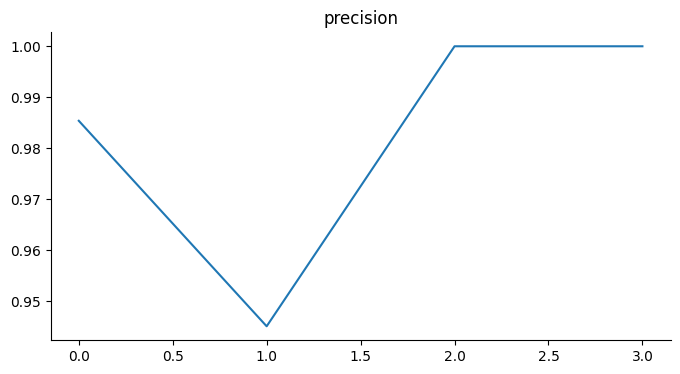

In [21]:
from matplotlib import pyplot as plt
df_sum['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

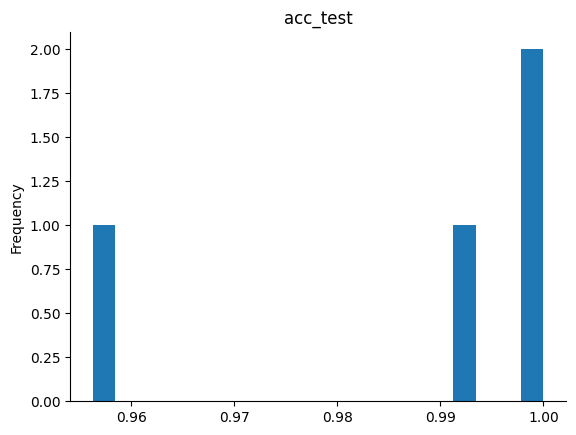

In [22]:
from matplotlib import pyplot as plt
df_sum['acc_test'].plot(kind='hist', bins=20, title='acc_test')
plt.gca().spines[['top', 'right',]].set_visible(False)

### 6) MVP Recomendado


### GRU escolhido como MVP:

**Tem melhor recall médio (identifica mais sinais relevantes).**

**Apresentou performance competitiva em todos os ativos, especialmente BBAS3 e CSNA3.**

**É mais leve e simples de treinar/manter do que LSTM.**

**Supera CNN1D em quase todos os aspectos.**

**O LSTM pode ser mantido como modelo de comparação, principalmente para cenários em que a precisão absoluta seja mais crítica do que o recall.**
**O CNN1D pode ser descartado no MVP, mas vale registrar a análise mostrando que não funcionou bem para este tipo de dado (isso fortalece o relatório acadêmico).**